# SyriaTel Customer Churn Project

## Business Understanding

SyriaTel, a telecommunications company, experiences customer churn at around 15%, meaning thousands of customers leave every year. This results in lost revenue, increased acquisition costs, and weakened customer loyalty. While churn prediction is a common use case, we aim to go beyond prediction by identifying the key behavioral and service-related factors driving churn. This will help SyriaTel target interventions effectively and reduce customer attrition.

This project aims:
- To build a predictive model that identifies customers at high risk of churn
- To identify key factors likely to make a customer churn; service quality, call charges, customer support
- To recommend actions that will reduce churn
- 5% reduction in churn rate through targeted retention strategies

Incase this dataset is imbalanced, accuracy alone is not a good measure. Instead, we will evaluate success using:
- Recall >= 85 (Sensitivity) for churn class - ensure the model identifies as many churners as possible, since missing them means lost revenue.
- Accuracy >=85 so predictions are overall correct
- F1-score - balance between Precision and Recall.
- AUC >= 0.85 -overall ability of the model to discriminate churners vs. non-churners.


# Data Understanding

### Columns description
- state: The U.S. state where the customer resides
- account length: Number of days the customer has had an account with SyriaTel
- area code: The customer’s telephone area code
- phone number: The unique phone number assigned to the customer.
- international plan: A binary indicator (yes/no) of whether the customer has subscribed to an international calling plan.
- voice mail plan: A binary indicator (yes/no) of whether the customer has subscribed to a voicemail plan. 
- number vmail messages: The number of voicemail messages recorded by the customer.
- total day minutes: The total number of minutes the customer used during daytime calls
- total day calls: The total number of calls made during the day.
- total day charge: The total charges incurred from daytime calls, directly proportional to total day minutes.
- total eve minutes: The total number of minutes the customer used during evening calls
- total eve calls: The total number of calls made during the evening.
- total eve charge: The total charges incurred from evening calls, directly proportional to total eve minutes.
- total night minutes: The total number of minutes the customer used during nighttime calls
- total night calls: The total number of calls made during the night.
- total night charge: The total charges incurred from nighttime calls, directly proportional to total night minutes.
- total intl minutes: The total number of minutes spent on international calls.
- total intl calls: The total number of international calls made by the customer.
- total intl charge: The total charges incurred from international calls, directly proportional to total intl minutes.
- customer service calls: The number of calls the customer made to customer service.
- churn: indicates whether the customer has churned (yes/no); Target variable


In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve,\
    classification_report, confusion_matrix, accuracy_score,\
          recall_score,precision_score,auc,make_scorer,average_precision_score
from sklearn.model_selection import train_test_split,GridSearchCV,\
      cross_validate,StratifiedKFold,StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE


In [2]:
#load datasets
df = pd.read_csv('bigml.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
df.tail()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False
3332,TN,74,415,400-4344,no,yes,25,234.4,113,39.85,...,82,22.60,241.4,77,10.86,13.7,4,3.70,0,False


observations: the columns are uniform

In [4]:
#shape of the dataset
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")

The dataset has 3333 rows and 21 columns


In [5]:
# investigate the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

observations:
- We will one hot encode the intl plan, voicemail plan and churn
- The dataset has no missing values

In [6]:
#stat summary
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
#unique values
for col in df:
    uniq_values = df[col].unique()
    print(f"{col}\n {df[col].unique()}\n")

state
 ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']

account length
 [128 107 137  84  75 118 121 147 117 141  65  74 168  95  62 161  85  93
  76  73  77 130 111 132 174  57  54  20  49 142 172  12  72  36  78 136
 149  98 135  34 160  64  59 119  97  52  60  10  96  87  81  68 125 116
  38  40  43 113 126 150 138 162  90  50  82 144  46  70  55 106  94 155
  80 104  99 120 108 122 157 103  63 112  41 193  61  92 131 163  91 127
 110 140  83 145  56 151 139   6 115 146 185 148  32  25 179  67  19 170
 164  51 208  53 105  66  86  35  88 123  45 100 215  22  33 114  24 101
 143  48  71 167  89 199 166 158 196 209  16  39 173 129  44  79  31 124
  37 159 194 154  21 133 224  58  11 109 102 165  18  30 176  47 190 152
  26  69 186 171  28 153 169  13  27   3  42 189 156 134 24

## Data Preparation

In [8]:
#make a copy
data = df.copy(deep=True)

In [9]:
#remove spaces in column names
data.columns = data.columns.str.replace(" ","_")
data.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

In [10]:
#change churn data type to object
data.churn = data['churn'].astype('O')


In [11]:
#drop phone numbers
del data['phone_number']
data

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


In [12]:
#check for duplicates,missing values
print(f"The dataset has {data.duplicated().sum()} duplicated values")
print(f"The dataset has: \n{data.isna().sum()} missing values")

The dataset has 0 duplicated values
The dataset has: 
state                     0
account_length            0
area_code                 0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64 missing values


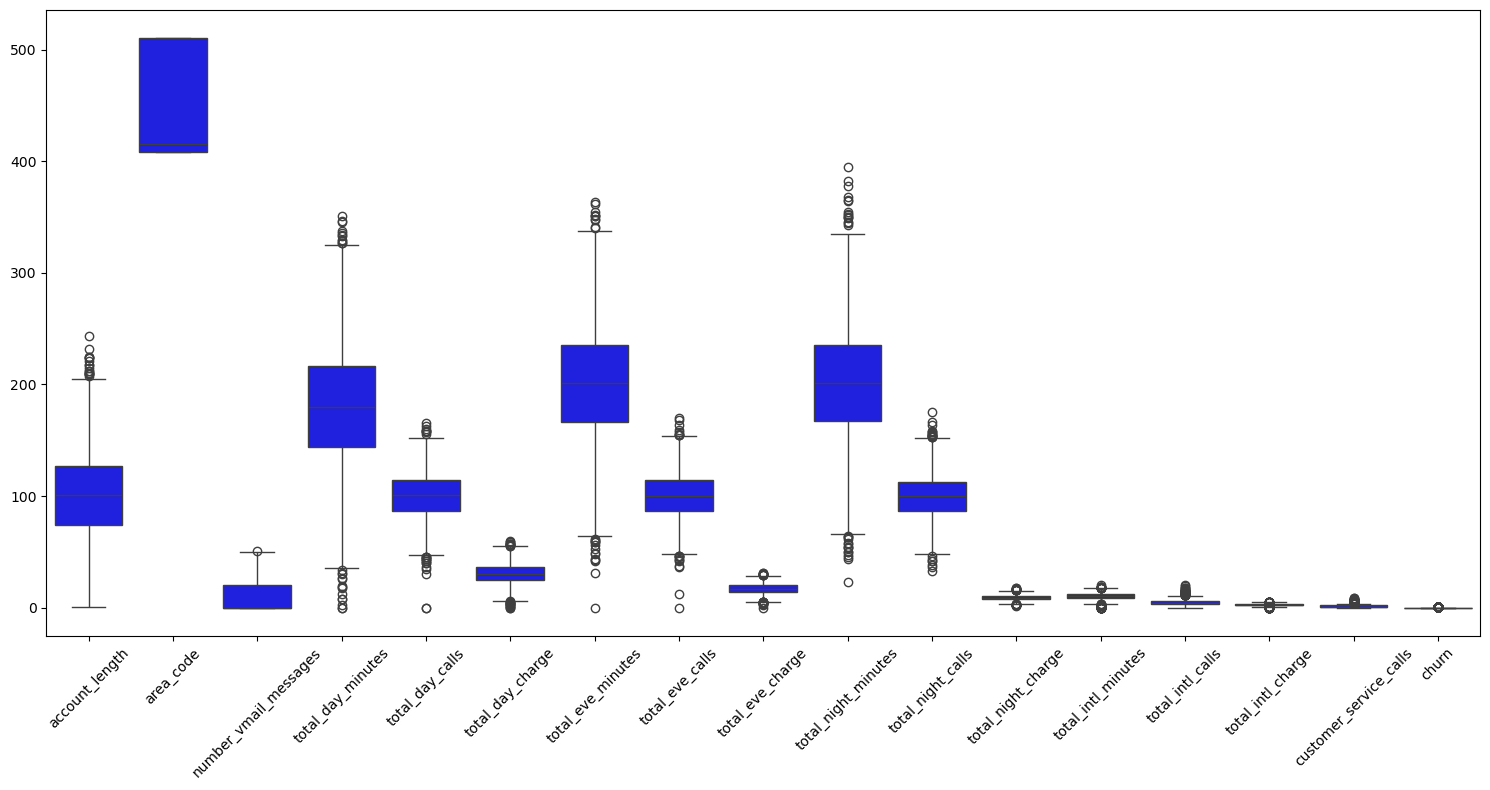

In [13]:
#check for outliers
plt.figure(figsize=(15,8))
sns.boxplot(data,color='blue')
plt.xticks(rotation=45)
plt.tight_layout()

Observations: The outliers are genuine
- Call times may vary depending on clients' job,location or lifestyle
- Call charges are dependent on time spend on call
- Customer service calls may increase as a result of complains from clients

In [14]:
#confirm data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   international_plan      3333 non-null   object 
 4   voice_mail_plan         3333 non-null   object 
 5   number_vmail_messages   3333 non-null   int64  
 6   total_day_minutes       3333 non-null   float64
 7   total_day_calls         3333 non-null   int64  
 8   total_day_charge        3333 non-null   float64
 9   total_eve_minutes       3333 non-null   float64
 10  total_eve_calls         3333 non-null   int64  
 11  total_eve_charge        3333 non-null   float64
 12  total_night_minutes     3333 non-null   float64
 13  total_night_calls       3333 non-null   int64  
 14  total_night_charge      3333 non-null   

In [15]:
#save the cleaned dataset
data.to_csv('clean_customer_churn.csv',index=False)

## Exploratory Data Analysis

### Univariate Analysis

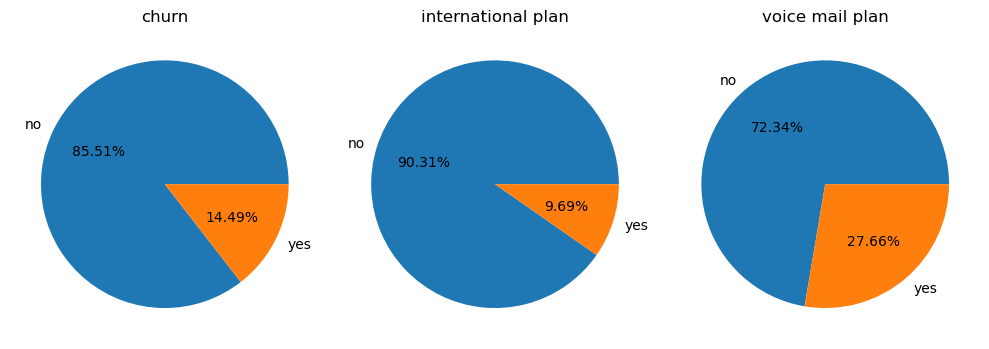

In [16]:
#check for imbalance in churn and plans
label = ['no','yes']
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
ax1.pie(data['churn'].value_counts(),autopct='%.2f%%',labels=label)
ax1.set_title("churn")
ax2.pie(data['international_plan'].value_counts(),autopct='%.2f%%',labels=label)
ax2.set_title("international plan")
ax3.pie(data['voice_mail_plan'].value_counts(),autopct='%.2f%%',labels=label)
ax3.set_title("voice mail plan")
plt.tight_layout();

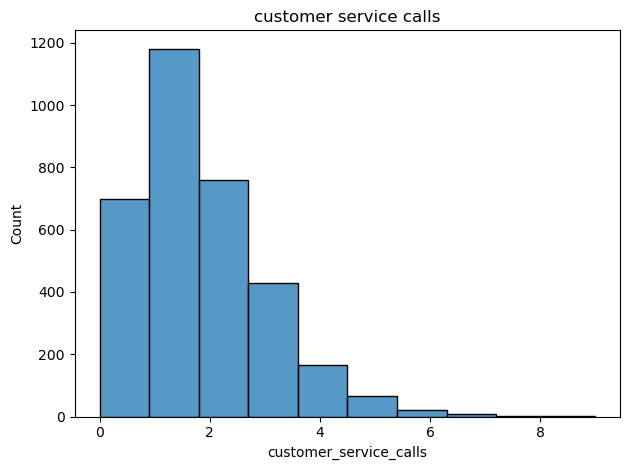

In [17]:
sns.histplot(data['customer_service_calls'],bins=10)
plt.title('customer service calls')
plt.tight_layout();

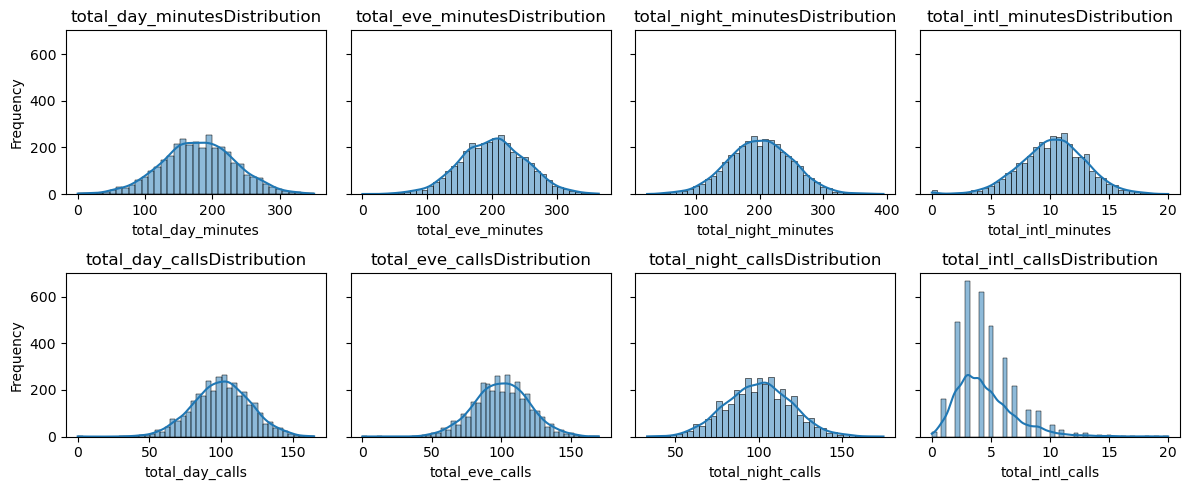

In [18]:
usage_cols = ['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes',
              'total_day_calls','total_eve_calls','total_night_calls','total_intl_calls']
fig,axes = plt.subplots(2,4,figsize=(12,5),sharey=True)
axes = axes.flatten()

for i,col in enumerate(usage_cols):
    sns.histplot(data[col],bins='auto',kde=True, ax=axes[i])
    axes[i].set_title(f"{col}Distribution")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    plt.tight_layout();

In [19]:
data.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'churn'],
      dtype='object')

Observations
- 15% of the customers churn; we have an imbalance
- Most customers call twice while few call upto 8 times; Do those who call more than 6 times churn?
- The usage columns are normally distributed apart from total internation calls
- customer service calls column is skewed to the right
- intl plan and voicemail plan columns are imbalanced; we may use SMOTE

### Bivariate analysis
- We will compare features to churn

p_value for international plan is 0.0000
p-value forvoice mail plan is 0.0000 


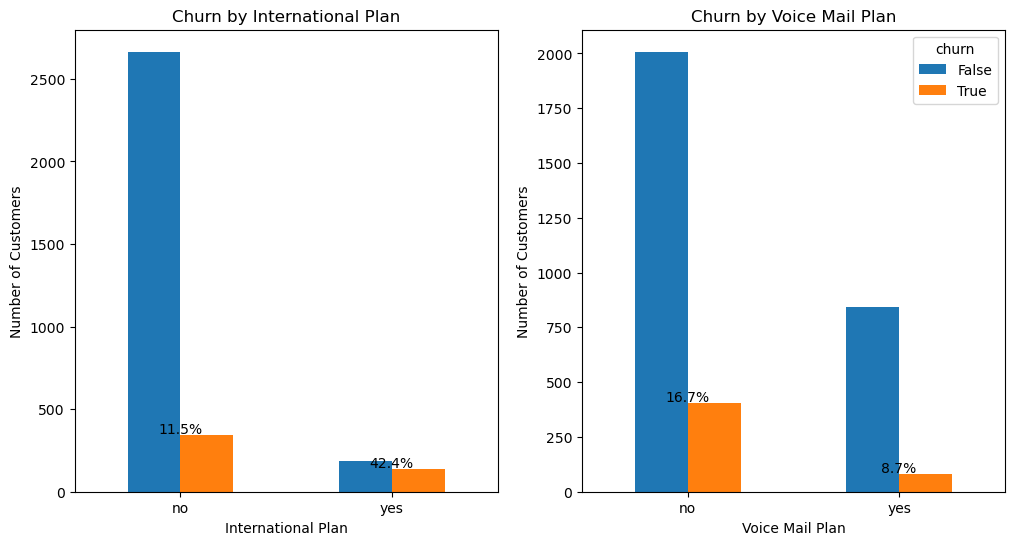

In [20]:
#H0: there is no association between customer plan and churn
# H1: there is an association between customer plan and churn

customer_plan = data[['international_plan','voice_mail_plan']]
chi = {}
for col in customer_plan:
    contigency = pd.crosstab(data[col],data['churn'])
    chi2,p_value,_,_ = chi2_contingency(contigency)
    chi[col] = p_value
print(f"p_value for international plan is {chi['international_plan']:.4f}\np-value forvoice mail plan is {chi['voice_mail_plan']:.4f} ")

#let's visualize to see the association
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Loop through both subplots and columns
for ax, col in zip(axes, customer_plan.columns):
    # Get contingency table
    customer_plan_ct = pd.crosstab(data[col], data['churn'])
    customer_plan_ct.plot(kind='bar', ax=ax, legend=(col == 'voice_mail_plan'))
    churn_rate = (customer_plan_ct[True] / customer_plan_ct.sum(axis=1)) * 100
    # Add churn % labels on top of orange bars

    for i in range(len(customer_plan_ct)):
        height = customer_plan_ct.iloc[i][True]
        percent = churn_rate.iloc[i]
        ax.text(i, height + 10, f"{percent:.1f}%", ha='center', color='black')

    # Titles and axis labels
    ax.set_title(f"Churn by {col.replace('_', ' ').title()}")
    ax.set_xlabel(col.replace('_', ' ').title())
    ax.set_ylabel("Number of Customers")
    ax.set_xticklabels(customer_plan_ct.index, rotation=0);


In [21]:
# H0: There is no significant difference in means of churn vs non-churn in a given numerical column
# H1: There is significant difference in means of churn vs non-churn in a given numerical column

num_cols = ['account_length', 'total_day_minutes','total_day_calls', 'total_eve_minutes','total_eve_calls', 'total_night_minutes',
             'total_night_calls', 'total_intl_minutes','total_intl_calls', 'customer_service_calls','number_vmail_messages','total_day_charge',
             'total_eve_charge','total_night_charge','total_intl_charge','area_code']
anova= []
for col in num_cols:
    group0 = data[data['churn']==0][col]
    group1 = data[data['churn']==1][col]
    t_stat,p_value = ttest_ind(group0,group1,equal_var=False)
    is_significant = p_value < 0.05
    anova.append({'Feature': col,'p-value': p_value,'Significant (<0.05)': is_significant})

anova_df = pd.DataFrame(anova)
anova_df = anova_df.sort_values(by='p-value')
print(anova_df[anova_df['Significant (<0.05)']])

                   Feature       p-value  Significant (<0.05)
1        total_day_minutes  1.218968e-20                 True
11        total_day_charge  1.219876e-20                 True
9   customer_service_calls  5.270040e-18                 True
10   number_vmail_messages  8.764782e-09                 True
3        total_eve_minutes  1.839080e-07                 True
12        total_eve_charge  1.842608e-07                 True
14       total_intl_charge  9.025887e-05                 True
7       total_intl_minutes  9.065715e-05                 True
8         total_intl_calls  3.185777e-03                 True
13      total_night_charge  3.027154e-02                 True
5      total_night_minutes  3.028049e-02                 True


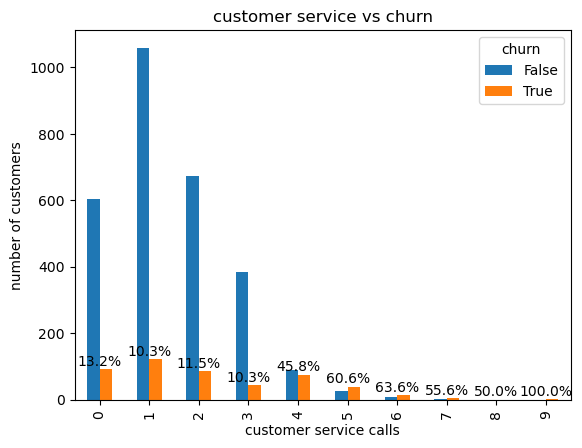

In [22]:
# customer service by churn
service_ct = pd.crosstab(data['customer_service_calls'],data['churn'])
ax5 = service_ct.plot(kind='bar')

service_churn_rate = (service_ct[True] / service_ct.sum(axis=1)) *100
service_bar_position = range(len(service_ct))
for i in service_bar_position:
    height_service = service_ct.iloc[i][True]
    service_percent = service_churn_rate.iloc[i]
    ax5.text(i, height_service + 10, f"{service_percent:.1f}%", ha='center', color='black')

plt.title('customer service vs churn')
plt.xlabel("customer service calls")
plt.ylabel('number of customers')
plt.legend(title='churn');

observations:
- Customers' plan are statistically significant, this means that we have an association between customer plan and churn
    - The churn rate for those with international plan is higher by about 30%
    - The churn rate for those without voice mail plan is higher by about 8%; they never get helped 

- For numerical values: 
    - total day minutes, total day charge, total eve minutes, total eve charge, total night minutes, total night charge, total intl minutes, total intl calls, total intl charge, customer service calls, number vmail messages are statistically significant; we reject H0

- Customer service calls vs churn
    - There is a 50% or more churn for customers who called 5 or more times

### Multivariate Analysis

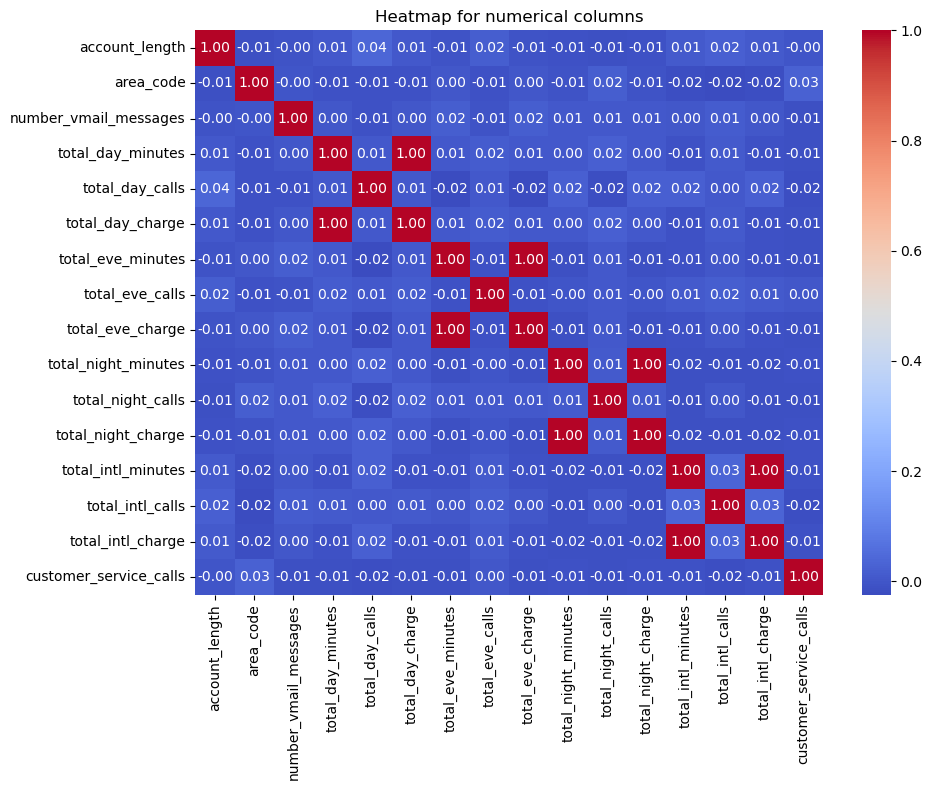

In [23]:

corr = data.select_dtypes("number").corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,cmap='coolwarm',annot=True, fmt='.2f')
plt.title("Heatmap for numerical columns")
plt.tight_layout();

Observation:
- total minutes and total charges are highly correlated, this could be because miutes was used to calculate charges
    - since we saw that charges were statistically significant to churn, we will use charges as opposed to minutes

### Feature Engineering

In [24]:
#aggregate columns
data['total_calls'] =data['total_day_calls']+ data['total_eve_calls']+ data['total_intl_calls']+data['total_night_calls']
data['total_charge'] = data['total_day_charge']+ data['total_eve_charge'] + data['total_intl_charge'] + data['total_night_charge']
data.columns

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge', 'customer_service_calls',
       'churn', 'total_calls', 'total_charge'],
      dtype='object')

In [25]:
#drop redundant features
data = data.drop(['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes','state'],axis=1)


## Modeling

### data preprocessing

In [26]:
data[:3]

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_calls,total_charge
0,128,415,no,yes,25,110,45.07,99,16.78,91,11.01,3,2.70,1,False,303,75.56
1,107,415,no,yes,26,123,27.47,103,16.62,103,11.45,3,3.70,1,False,332,59.24
2,137,415,no,no,0,114,41.38,110,10.30,104,7.32,5,3.29,0,False,333,62.29


In [27]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Columns: 17 entries, account_length to total_charge
dtypes: float64(5), int64(9), object(3)
memory usage: 442.8+ KB


In [28]:
#label encode the target variable
le = LabelEncoder()
data['churn'] = le.fit_transform(data['churn'])

In [29]:
#one hot encode intl plan and voice mail plan features
cat = data[['international_plan','voice_mail_plan']]
cat_ohe = pd.get_dummies(cat,drop_first=True,dtype='int')

#merge the original data with the new cat columns
merged_df = pd.concat([data,cat_ohe],axis=1)
#drop the initial cat columns
merged_df.drop(columns=cat.columns, inplace=True,axis=1)
merged_df[:3]


,account_length,area_code,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_calls,total_charge,international_plan_yes,voice_mail_plan_yes
0,128,415,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0,303,75.56,0,1
1,107,415,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0,332,59.24,0,1
2,137,415,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0,333,62.29,0,0


In [30]:
# separate features and target
X = merged_df.drop("churn",axis=1)
y = merged_df.churn


#split to train and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape ,X_test.shape ,y_train.shape ,y_test.shape

((2666, 16), (667, 16), (2666,), (667,))

In [31]:
#check for correlation
merged_df.corr()['churn'].sort_values(ascending=False)

churn                     1.000000
international_plan_yes    0.259852
total_charge              0.231549
customer_service_calls    0.208750
total_day_charge          0.205151
total_eve_charge          0.092786
total_intl_charge         0.068259
total_night_charge        0.035496
total_day_calls           0.018459
account_length            0.016541
total_calls               0.015807
total_eve_calls           0.009233
area_code                 0.006174
total_night_calls         0.006141
total_intl_calls         -0.052844
number_vmail_messages    -0.089728
voice_mail_plan_yes      -0.102148
Name: churn, dtype: float64

In [32]:
#balance the training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)
#check on whether SMOTEN worked
print(f" Original values \n {y_train.value_counts()}\n")
print(f"Smoted values \n {y_train_sm.value_counts()}")

 Original values 
 churn
0    2280
1     386
Name: count, dtype: int64

Smoted values 
 churn
0    2280
1    2280
Name: count, dtype: int64


In [33]:
#scaling featues
ss = StandardScaler()
X_train_s = ss.fit_transform(X_train_sm)
X_test_s = ss.transform(X_test)


              Model  train score  Accuracy  Recall  Precision  F1 score   AUC
logistic regression         0.79     75.11   65.98      32.49     43.54 71.32
      Decision tree         1.00     85.61   82.47      50.31     62.50 84.31
      Random Forest         1.00     93.25   70.10      80.95     75.14 83.65
            Xgboost         1.00     88.76   79.38      58.33     67.25 84.87


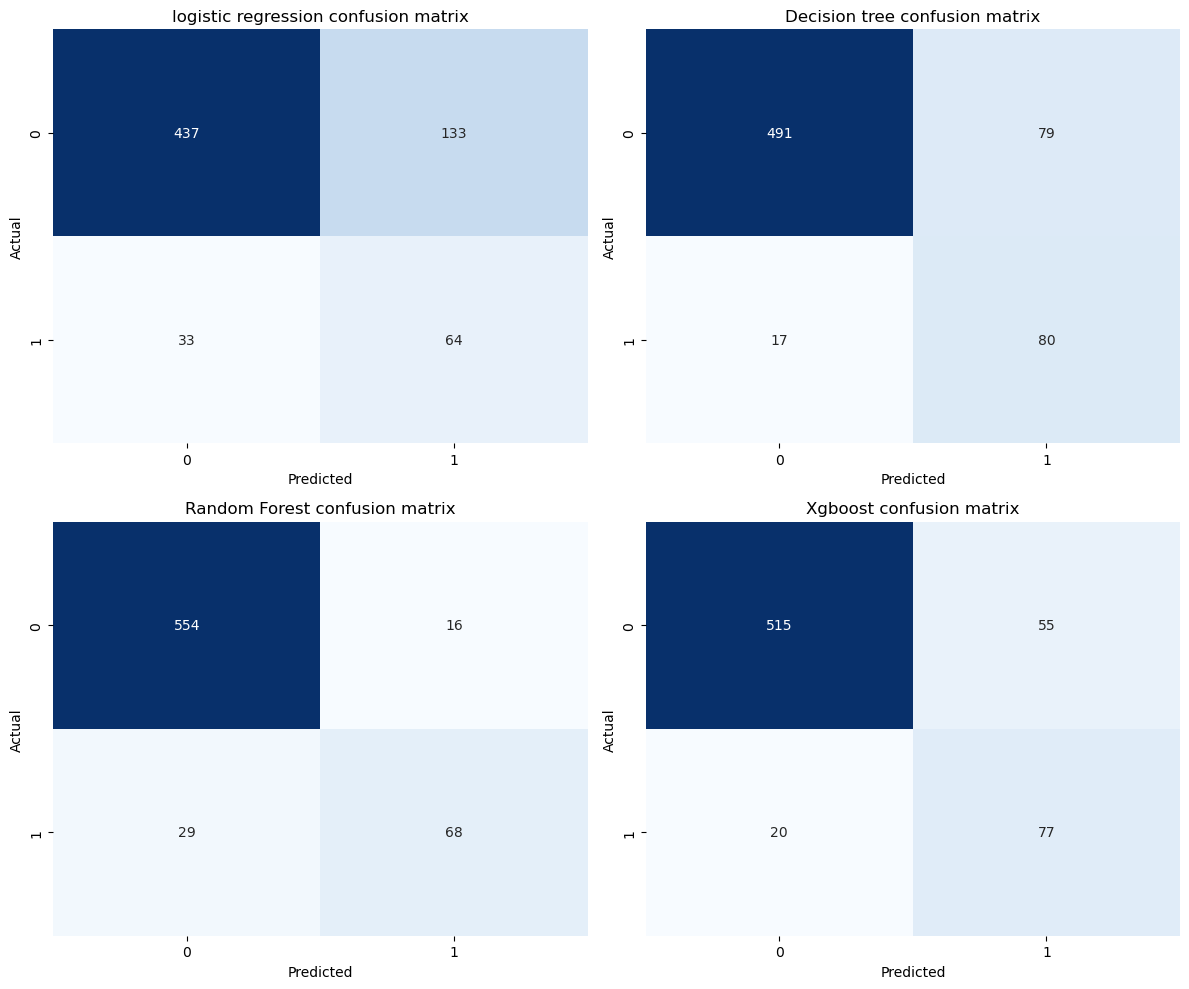

In [34]:
#fit models
models = {'logistic regression':LogisticRegression(random_state=42,max_iter=1000),
          'Decision tree': DecisionTreeClassifier(random_state=42),
          'Random Forest':RandomForestClassifier(random_state=42,n_estimators=200,class_weight='balanced'),
          'Xgboost':XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss',scale_pos_weight=(y == 0).sum() / (y == 1).sum())
          }
results = []
conf_matrix = {}
for name, model in models.items():
    model.fit(X_train_s,y_train_sm)
    y_pred = model.predict(X_test_s)
    y_prob = model.predict_proba(X_test_s)[:,1]

    results.append({'Model':name,
                    'train score':model.score(X_train_s,y_train_sm),
                    'Accuracy':accuracy_score(y_test,y_pred)*100,
                    'Recall':recall_score(y_test,y_pred)*100,
                    'Precision':precision_score(y_test,y_pred)*100,
                    'F1 score':f1_score(y_test,y_pred)*100,
                    'AUC':roc_auc_score(y_test,y_pred)*100
                })
    conf_matrix[name] = confusion_matrix(y_test,y_pred)

results_df = pd.DataFrame(results).round(2)
results_df = results_df[["Model",'train score', "Accuracy", "Recall", "Precision", "F1 score", "AUC"]]
print(results_df.to_string(index=False))

#confusion matrix
fig, axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.flatten()
for i, (name,cm) in enumerate (conf_matrix.items()):
    sns.heatmap(cm, annot=True, cbar=False,cmap='Blues',fmt='d', ax=axes[i])
    axes[i].set_title(f'{name} confusion matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()

Observation:
- Logistic regression misses a fair number of churners; very expensive
- Decision tree has a high recall but
- Random forest would be better if our priority was precision
- Xgboost is the best model with a balance of precision and recall (F1)

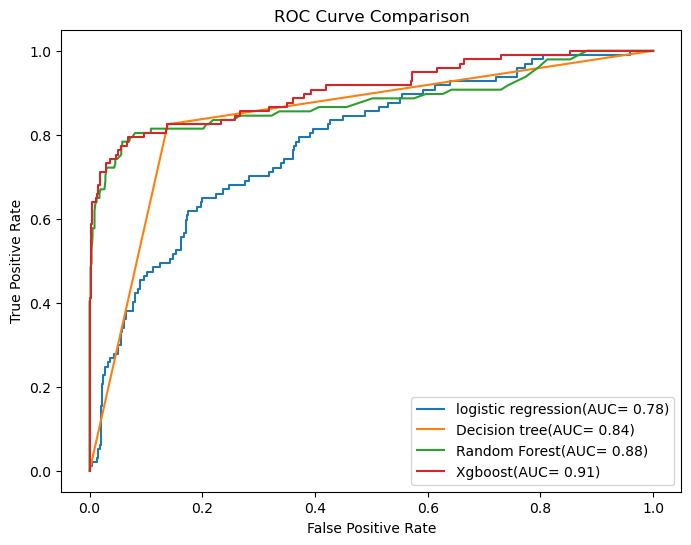

In [35]:
#plot the roc for all models
plt.figure(figsize=(8,6))
for name,model in models.items():
    y_prob = model.predict_proba(X_test_s)[:,1]
    fpr,tpr,_= roc_curve(y_test,y_prob)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f"{name}(AUC= {roc_auc:.2f})")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend();

observations:
- Decision tree has a recall closest to our metrics of success
- So far, Xgboost is the best model to use.
- Based on our measure of success, xgboost has a recall of less than 85
- We focus on tuning it to improve the recall but first we will use cross validation

In [36]:
#using cross validation
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
}

# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = {}
for name, model in models.items():
    cv_result = cross_validate(
        model,
        X_res, y_res,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
    cv_results[name] = {
        metric: cv_result['test_' + metric].mean() * 100
        for metric in scoring.keys()
    }
    cv_results[name]['train_accuracy'] = cv_result['train_accuracy'].mean() * 100

# ---- Results DataFrame ----
cv_results_df = pd.DataFrame(cv_results).T.round(2)
print(cv_results_df)


                     accuracy  recall  precision     f1  train_accuracy
logistic regression     89.60   82.49      96.16  88.80           89.63
Decision tree           86.75   88.84      85.31  87.02          100.00
Random Forest           94.84   92.21      97.35  94.70          100.00
Xgboost                 93.96   95.58      92.62  94.07           99.96


observation:
- we will use cross validation to split our dataset
- xgboost seems to be the best model to use
- we will hyperparameter tune to find the right parameters to use

In [37]:
#hyperparameter tuning
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

base_models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42,class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42) 
}


param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"],
        "max_iter": [2000, 5000, 10000]  
    },
    "Decision Tree": {
        "max_depth": [3, 5, 10],
        "min_samples_split": [5, 10, 20],
        "min_samples_leaf": [2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, 15],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [2, 5]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.05, 0.1, 0.2],
        "subsample": [0.8, 1],
        "colsample_bytree": [0.8, 1],
        "reg_lambda": [1, 5],
        "reg_alpha": [0, 1]
    }
}

scoring = {
    "accuracy": "accuracy",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
cv_results = {}

for name, model in base_models.items():

    grid = GridSearchCV(
        model,
        param_grids[name],
        cv=cv,
        scoring="recall",  
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_res, y_res)
    best_model = grid.best_estimator_
    
    if name == "Decision Tree":
        best_model = CalibratedClassifierCV(best_model, cv=5)
        best_model.fit(X_res, y_res)

    best_models[name] = best_model

    cv_result = cross_validate(
        best_model,
        X_res, y_res,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
    cv_results[name] = {
        metric: cv_result["test_" + metric].mean() * 100
        for metric in scoring.keys()
    }
    cv_results[name]["train_accuracy"] = cv_result["train_accuracy"].mean() * 100
    cv_results[name]["best_params"] = grid.best_params_

cv_results_df = pd.DataFrame(cv_results).T
cv_results_df = cv_results_df.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

print(cv_results_df)



/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

                     accuracy  recall  precision     f1  roc_auc  pr_auc  \
Logistic Regression     89.56   83.33      95.20  88.87    95.43   96.54   
Decision Tree           87.91   80.67      94.34  86.97    94.30   95.55   
Random Forest           92.74   87.86      97.36  92.36    98.10   98.40   
XGBoost                 95.05   93.26      96.73  94.96    98.58   98.84   

                     train_accuracy  \
Logistic Regression           89.67   
Decision Tree                 91.58   
Random Forest                 98.88   
XGBoost                      100.00   

                                                           best_params  
Logistic Regression      {'C': 0.1, 'max_iter': 5000, 'penalty': 'l2'}  
Decision Tree        {'max_depth': 10, 'min_samples_leaf': 5, 'min_...  
Random Forest        {'max_depth': 15, 'min_samples_leaf': 2, 'min_...  
XGBoost              {'colsample_bytree': 1, 'learning_rate': 0.2, ...  


observation:
Model  train score  Accuracy  Recall  Precision  F1 score   AUC
logistic regression         0.79     75.11   65.98      32.49     43.54 71.32
      Decision tree         1.00     85.61   82.47      50.31     62.50 84.31
      Random Forest         1.00     93.25   70.10      80.95     75.14 83.65
            Xgboost         1.00     88.76   79.38      58.33     67.25 84.87
- Imbalance handled with SMOTE; recall boosted from 65% (Logistic baseline) to >90% (XGBoost).
- Overfitting addressed; Decision Tree pruned with parameters
- from feature importance: international plan, customer service calls, and high day charges.
- Business Value: With XGBoost, we can now identify >93% of churners, directly supporting customer retention strategies.

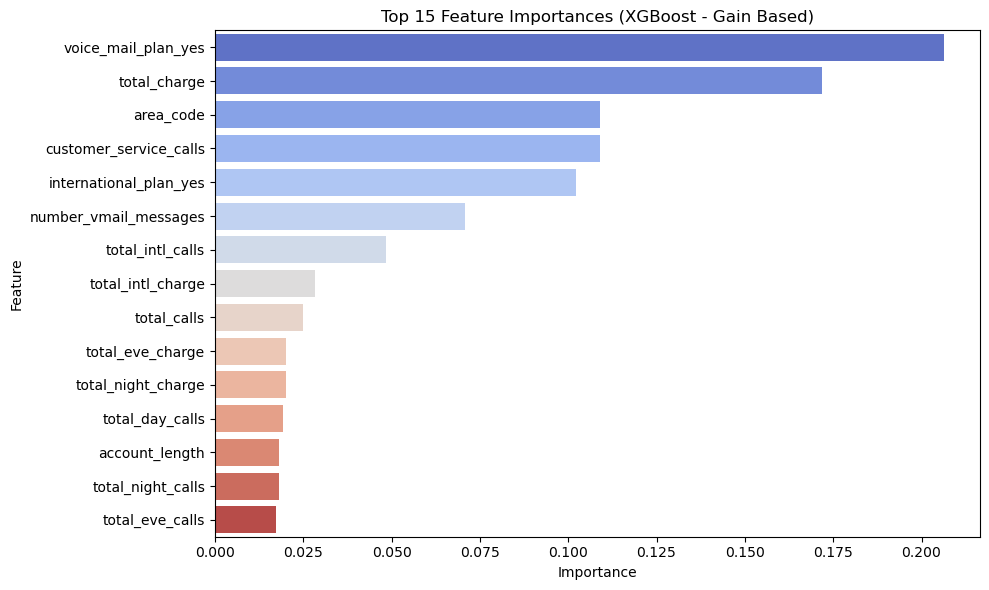

In [38]:
#Feature Importance using XGBoost
best_xgb = best_models["XGBoost"]  

xgb_importances = best_xgb.feature_importances_
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15), palette="coolwarm")
plt.title("Top 15 Feature Importances (XGBoost - Gain Based)")
plt.tight_layout()
plt.show()



observation:
- The strongest signals of customer churn are:voicemail plan, total charge, area code, customer service calls, International plan, Number of voicemails, total international calls

- Business Implication: Customers who frequently contact customer service, have an international plan, or have unusually high call charges are more likely to churn. These are red flags for intervention.

- Model Confidence: Since XGBoost had both the highest recall of 93% and generalization power (train 100% vs test 95% showing only mild overfit), it is the most suitable model for deployment.

Conclusions:
1. Target High-Risk Customers: proactive retention campaigns (discounts, offers, loyalty programs). 

2. Improve Customer Service: Reduce wait times, improve first-call resolution. 

3. Personalized Plans: Tailor plans to heavy users (day/evening minutes). 

4. Review International Plan: Reassess pricing and benefits.